# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.losses import SparseCategoricalCrossentropy
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

% matplotlib inline

print(tf.__version__)


2.9.1


In [6]:
!pip install git+https: // github.com / tensorflow / docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to c:\users\gonca\appdata\local\temp\pip-req-build-en9nkq6u
  Resolved https://github.com/tensorflow/docs to commit b8d090113861d46bf007c087c089cb8442d41060
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs 'C:\Users\gonca\AppData\Local\Temp\pip-req-build-en9nkq6u'


# Carregamento de dados

In [4]:
TRAINING_DATASET_SOURCE = 'training_data.csv'
TEST_DATASET_SOURCE = 'test_data.csv'

train_df = pd.read_csv(TRAINING_DATASET_SOURCE)
test_df = pd.read_csv(TEST_DATASET_SOURCE)

# SEED utilizada

In [5]:
SEED = 101

# Preparação dos dados

In [51]:

#### Data Preparation
def neural_network_data_preparation(df: pd.DataFrame) -> pd.DataFrame:
    dropped_columns = ['city_name', 'magnitude_of_delay', 'avg_precipitation']

    prep_df = df.drop(dropped_columns, axis=1)

    ### Agrupar em 2 bins a feature 'avg_rain'
    prep_df.loc[prep_df['avg_rain'] == 'Sem Chuva', 'rain'] = 0
    prep_df.loc[prep_df['avg_rain'] != 'Sem Chuva', 'rain'] = 1

    prep_df.drop(columns=['avg_rain'], inplace=True)

    ### Agrupar em 2 bins a feature 'delay_in_seconds'
    prep_df.loc[prep_df['delay_in_seconds'] == 0, 'delay'] = 0  # 'NONE'
    prep_df.loc[prep_df['delay_in_seconds'] >= 1, 'delay'] = 1  # 'DELAYED'

    prep_df.drop(columns=['delay_in_seconds'], inplace=True)

    ### Agrupar em 3 bins a feature 'luminosity'
    prep_df.loc[prep_df['luminosity'] == 'LOW_LIGHT', 'luminosity_binned'] = 0
    prep_df.loc[prep_df['luminosity'] == 'LIGHT', 'luminosity_binned'] = 1
    prep_df.loc[prep_df['luminosity'] == 'DARK', 'luminosity_binned'] = 2

    prep_df.drop(columns=['luminosity'], inplace=True)

    ### Extrair a hora e dia da semana da feature 'record_date'
    record_date = pd.DatetimeIndex(prep_df['record_date'])

    prep_df['record_date_hour'] = record_date.hour
    prep_df['record_date_day'] = record_date.day
    prep_df['record_date_month'] = record_date.month
    prep_df['record_date_weekday'] = record_date.weekday

    prep_df.drop(columns=['record_date'], inplace=True)

    ### Agrupar em 3 bins a feature 'avg_temperature'

    prep_df.loc[prep_df['avg_temperature'].between(0, 10, 'right'), 'temperature'] = 0  #'LOW'
    prep_df.loc[prep_df['avg_temperature'].between(10, 19, 'both'), 'temperature'] = 1  #'MEAN'
    prep_df.loc[prep_df['avg_temperature'].between(19, 35, 'right'), 'temperature'] = 2  #'HIGH'

    prep_df.drop(columns=['avg_temperature'], inplace=True)

    ### Quantificar a feature 'affected_roads' para o número único de estradas afetadas
    road_quantity = []
    for line in prep_df['affected_roads']:
        res = set(str(line).split(','))
        res2 = [elem for elem in res if elem != '']
        count = len(res2)
        road_quantity.append(count)

    prep_df['affected_roads'] = road_quantity

    ### (?) Remover outliers da feature 'avg_wind_speed'

    # outliers = train_df["avg_wind_speed"].quantile(8.0)
    # X.drop(X[X['avg_wind_speed'] >= 8.0].index, inplace=True)

    ### Target
    if 'incidents' in prep_df.columns:
        prep_df.loc[prep_df['incidents'] == 'None', 'incidents_binned'] = 0  # 'None'
        prep_df.loc[prep_df['incidents'] == 'Low', 'incidents_binned'] = 1  # 'Low'
        prep_df.loc[prep_df['incidents'] == 'Medium', 'incidents_binned'] = 2  # 'Medium'
        prep_df.loc[prep_df['incidents'] == 'High', 'incidents_binned'] = 3  #'High'
        prep_df.loc[prep_df['incidents'] == 'Very_High', 'incidents_binned'] = 4  #'Very_High'

        prep_df.drop(columns=['incidents'], inplace=True)

    return prep_df

In [52]:
X = neural_network_data_preparation(train_df)
y = X['incidents_binned']

X.drop(columns=['incidents_binned'], inplace=True)

C:\Users\gonca\.conda\envs\DAA\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- incidents_binned

  warnings.warn(message, FutureWarning)


ValueError: X has 12 features, but MinMaxScaler is expecting 13 features as input.

In [52]:
scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = pd.DataFrame(scaler_X.transform(X[X.columns]), columns=X.columns)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=SEED)

(4000, 12)

# Construção da estrutura da rede neuronal

In [17]:
def build_model(activation='relu', learning_rate=0.01):
    # Create a sequential model (with three layers - last one is the output)
    model = Sequential(
        [
            Dense(16, input_dim=12, activation=activation),
            Dense(8, activation=activation),

            # Output Layer
            Dense(5, activation='sigmoid')
            # Dense(1, activation='softmax')
        ]
    )

    # Model compilation
    model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

    return model


In [18]:
model = build_model()

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                208       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 45        
Total params: 389
Trainable params: 389
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=20)

Epoch 1/50
200/200 [==============================] - 0s 2ms/step - loss: 1.4420 - accuracy: 0.4405 - val_loss: 1.3188 - val_accuracy: 0.5050
Epoch 2/50
200/200 [==============================] - 0s 1ms/step - loss: 1.2449 - accuracy: 0.5077 - val_loss: 1.1792 - val_accuracy: 0.5270
Epoch 3/50
200/200 [==============================] - 0s 1ms/step - loss: 1.1426 - accuracy: 0.5240 - val_loss: 1.1149 - val_accuracy: 0.5220
Epoch 4/50
200/200 [==============================] - 0s 1ms/step - loss: 1.0870 - accuracy: 0.5242 - val_loss: 1.0816 - val_accuracy: 0.5250
Epoch 5/50
200/200 [==============================] - 0s 1ms/step - loss: 1.0546 - accuracy: 0.5322 - val_loss: 1.0599 - val_accuracy: 0.5360
Epoch 6/50
200/200 [==============================] - 0s 1ms/step - loss: 1.0302 - accuracy: 0.5428 - val_loss: 1.0421 - val_accuracy: 0.5540
Epoch 7/50
200/200 [==============================] - 0s 976us/step - loss: 1.0132 - accuracy: 0.5570 - val_loss: 1.0248 - val_accuracy: 0.5720
Epoc

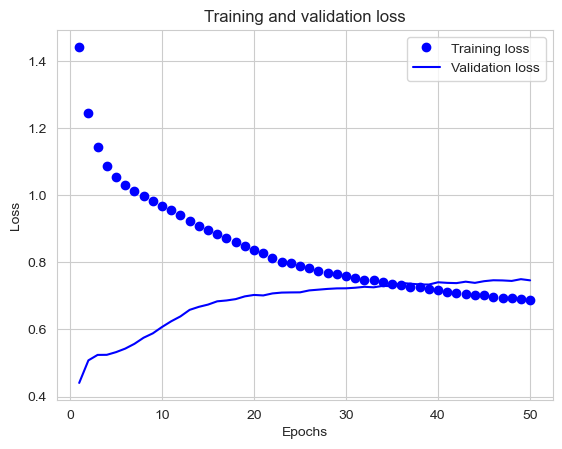

In [20]:
history_dict = history.history

acc = history_dict['accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, acc, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [21]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 0s 501us/step - loss: 0.6883 - accuracy: 0.7470


In [32]:
# probability_model = Sequential([model, tf.keras.layers.Dense(1, activation='softmax')])

In [49]:
predicts = model.predict(X_test)

categories_predicted = [np.argmax(pred) for pred in predicts]

categories_predicted

[0,
 4,
 4,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 1,
 4,
 3,
 3,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 4,
 3,
 0,
 1,
 1,
 0,
 0,
 3,
 3,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 3,
 3,
 0,
 3,
 3,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 4,
 0,
 0,
 0,
 3,
 0,
 4,
 0,
 0,
 3,
 1,
 1,
 0,
 1,
 4,
 4,
 1,
 0,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 1,
 2,
 3,
 4,
 1,
 4,
 0,
 3,
 0,
 3,
 1,
 3,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 4,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 1,
 4,
 0,
 1,
 0,
 3,
 1,
 1,
 3,
 0,
 3,
 0,
 3,
 4,
 3,
 0,
 0,
 0,
 3,
 0,
 2,
 1,
 0,
 0,
 1,
 0,
 4,
 1,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 3,
 3,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 2,
 1,
 2,
 4,
 0,
 0,
 1,
 3,
 0,
 1,
 0,
 1,
 0,
 4,
 1,
 3,
 0,
 4,
 0,
 3,
 1,
 3,
 4,
 0,
 3,
 0,
 3,
 0,
 0,
 0,
 3,
 3,
 4,
 0,
 0,
 3,
 0,
 0,
 4,
 3,
 0,
 0,
 0,
 0,
 1,
 0,
 3,
 3,
 0,
 3,
 0,
 1,
 0,
 4,
 0,
 0,
 0,
 4,
 4,
 0,
 3,
 1,
 0,
 4,
 3,
 1,
 0,
 1,
 3,
 3,
 0,
 3,
 4,
 2,
 4,
 3,
 0,
 0,
 0,
 0,
 3,


In [25]:
y_test

1718    0.0
2511    1.0
345     1.0
2521    0.0
54      0.0
       ... 
3900    4.0
3753    0.0
3582    3.0
2392    0.0
3343    4.0
Name: incidents_binned, Length: 1000, dtype: float64

In [ ]:
TUNING_DICT = {
    'activation': ['relu', 'sigmoid'],
    'learning_rate': [0.01, 0.001]
}

# KFolding

In [63]:
#### Não funciona atualmente!

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

grid_search = GridSearchCV(estimator=model,
                           param_grid=TUNING_DICT,
                           cv=kf,
                           scoring='accuracy',
                           refit=True,
                           error_score="raise",
                           verbose=3)

grid_search.fit(X_train, y_train, validation_split=0.2)

NameError: name 'TUNING_DICT' is not defined

## Resultados

In [ ]:
#summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [41]:
best_mlp_model = grid_search.best_estimator_
#Obtain predictions
predictions = best_mlp_model.predict(X_test)
predictions = predictions.reshape(predictions.shape[0], 1)
predictions[:5]

plt.scatter(y_test, predictions)


NameError: name 'grid_search' is not defined

# Obter as previsões no dataset de submissão

In [54]:
X = neural_network_data_preparation(test_df)

scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = pd.DataFrame(scaler_X.transform(X[X.columns]), columns=X.columns)

X_scaled

,affected_roads,avg_atm_pressure,avg_humidity,avg_wind_speed,rain,delay,luminosity_binned,record_date_hour,record_date_day,record_date_month,record_date_weekday,temperature
0,0.142857,0.59375,0.784946,0.000000,0.0,1.0,0.5,0.826087,0.400000,0.272727,0.166667,0.5
1,0.142857,0.59375,0.365591,0.222222,0.0,0.0,1.0,0.173913,0.400000,0.818182,0.333333,0.5
2,0.142857,0.56250,0.688172,0.000000,0.0,0.0,0.5,0.826087,0.566667,0.545455,1.000000,1.0
3,0.285714,0.28125,0.795699,0.333333,0.0,1.0,0.5,0.652174,0.966667,0.818182,0.833333,0.5
4,0.142857,0.71875,0.849462,0.000000,0.0,0.0,0.5,0.434783,0.566667,0.818182,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1201,0.142857,0.81250,0.677419,0.222222,0.0,0.0,0.5,0.434783,1.000000,1.000000,0.666667,0.5
1202,0.142857,0.53125,0.344086,0.222222,0.0,1.0,1.0,0.000000,0.500000,0.545455,0.666667,1.0
1203,0.142857,0.59375,0.569892,0.000000,0.0,1.0,0.5,0.652174,0.600000,1.000000,1.000000,0.5
1204,0.142857,0.50000,0.462366,0.111111,0.0,1.0,0.5,0.739130,0.233333,0.181818,0.000000,0.5


In [61]:
from sklearn import preprocessing

incidents_enconder = preprocessing.LabelEncoder()

incidents_enconder.fit(['None', 'Low', 'Medium', 'High', 'Very_High'])

LabelEncoder()

In [62]:
predictions = categories_predicted = [np.argmax(pred) for pred in model.predict(X_scaled)]

predictions = incidents_enconder.inverse_transform(predictions)

predictions_df = pd.DataFrame(predictions)

predictions_df.index += 1

predictions_df.to_csv("submission.csv", header=['Incidents'], index_label='RowId')